# parallelism across multiple GPUs

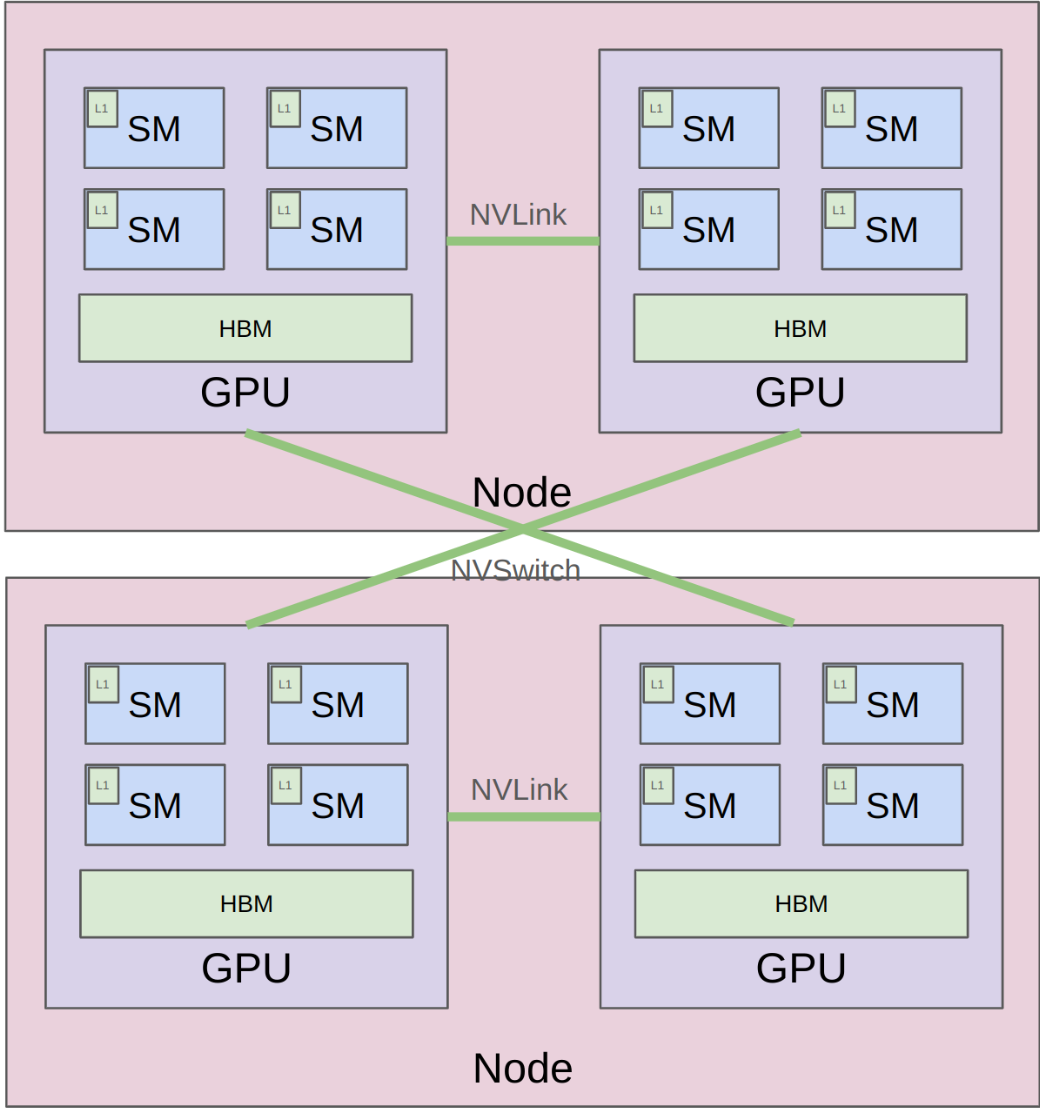
复习一下GPU的内部图：
有多个node,每一个中配备有GPU,在每一个GPU内部，都有一系列流式多处理器（SM），它们是实际执行工作的部分，在每一个SM中会有一个L1 cache,绿色的通道部分是memory 和 communication ,在GPU上,配备了高宽带内存（HBM）,它的容量很大

 - 计算必须在SM内部执行，由这些ALU来执行
 - 每次计算都会由输入和输出，而输入输出都可能离计算单元较远：如果比较幸运，那么在L1 cache中，不然有可能在HBM中

 - multi GPU:所需要的数据可能在另一个GPU上
 - 关键点：如何组织计算以防止数据传输成为性能瓶颈
 

 - Generalized hierarchy (from small/fast to big/slow):
    
    Single node, single GPU: L1 cache / shared memory
        
    Single node, single GPU: HBM
        
    Single node, multi-GPU: NVLink
        
    Multi-node, multi-GPU: NVSwitch

## collective operation(其实就指代是并行化中涉及多个节点的操作)
 - Terminology（基础原语）:
    World size: number of devices (e.g., 4)
    Rank: a device (e.g., 0, 1, 2, 3)

 - 几个原语
 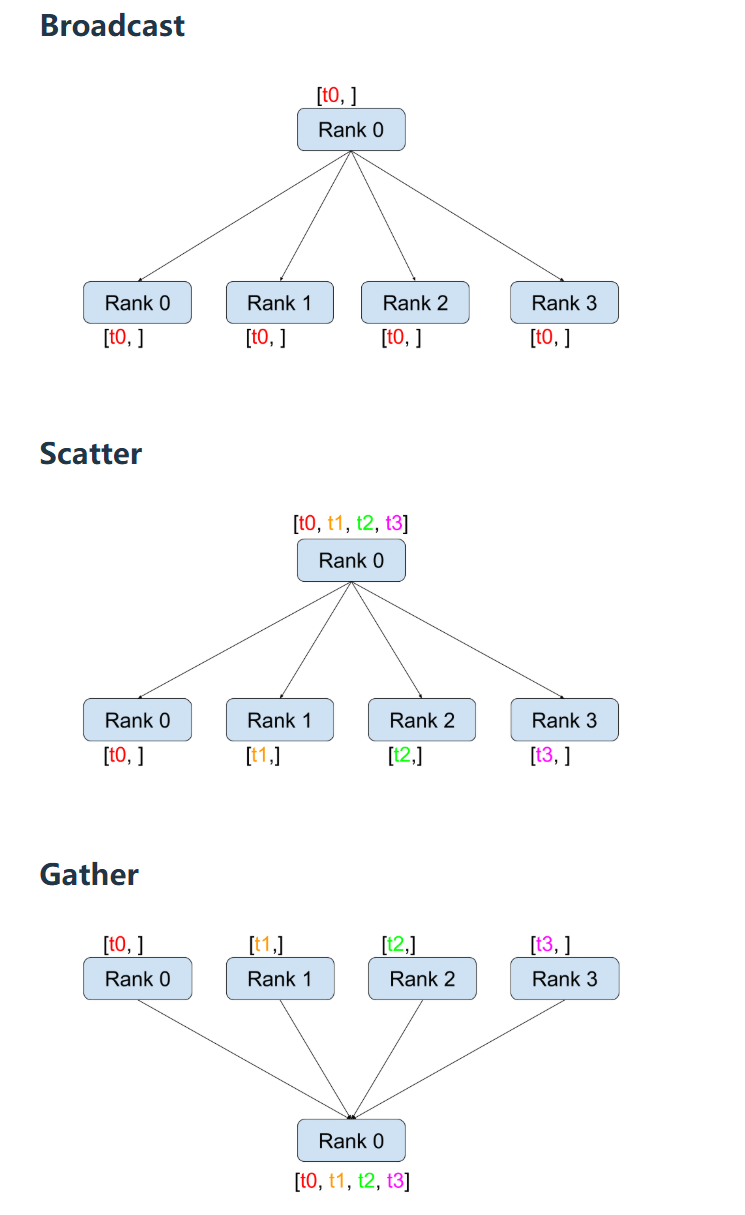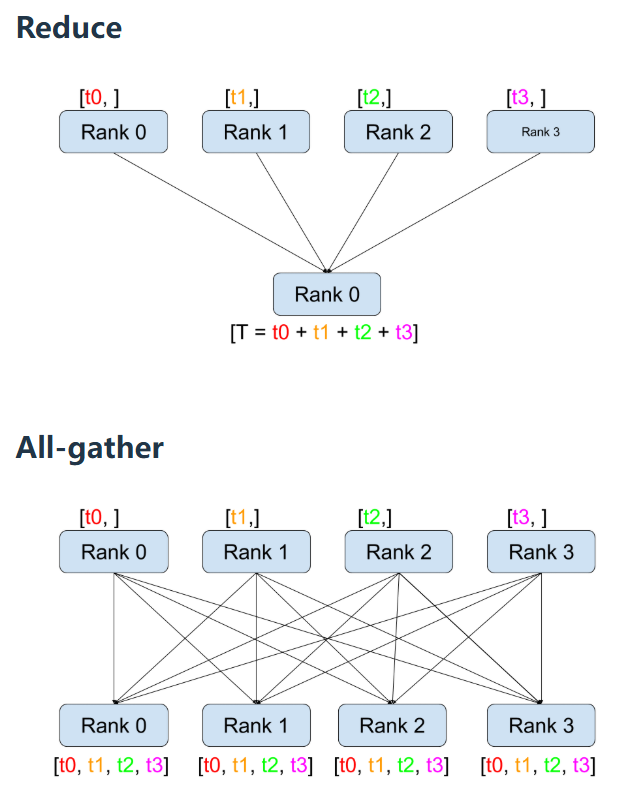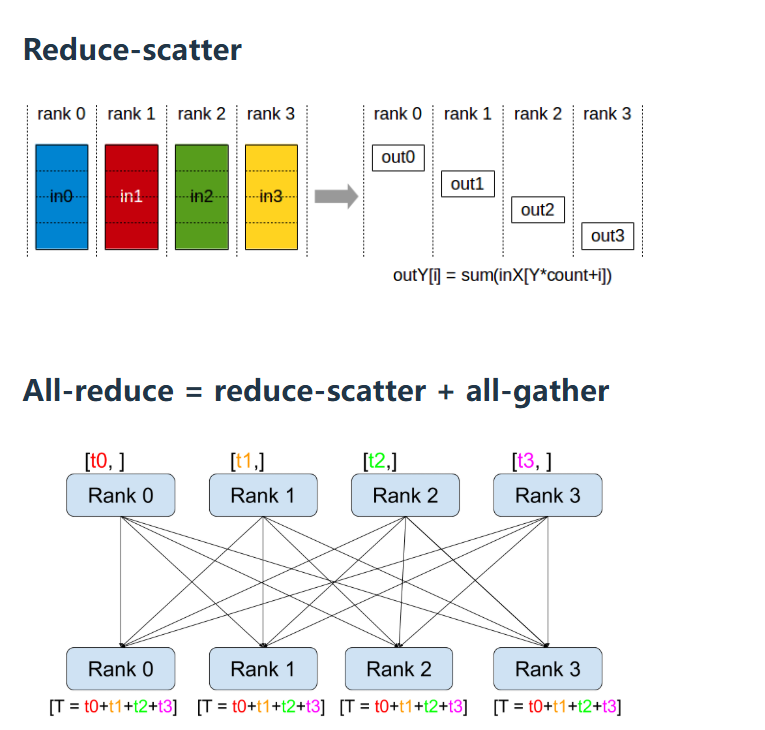


  - 一些记忆原语的小技巧

   Reduce: performs some associative/commutative operation (sum, min, max)
      
   Broadcast/scatter is inverse of gather
      
   All: means destination is all devices



### hardware for GPUs looks like
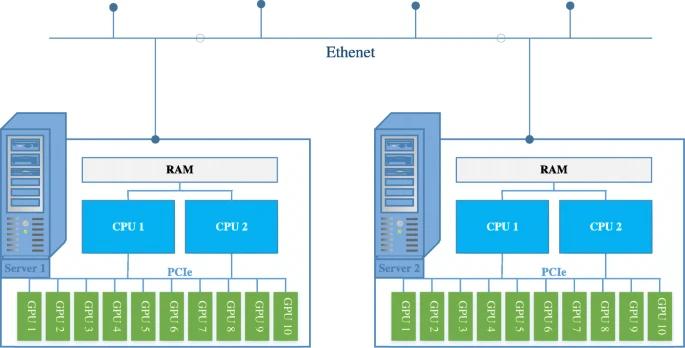
  
 - GPUs on same node communicate via a PCI(e) bus (v7.0, 16 lanes => 242 GB/s)
 [article]
    
 - GPUs on different nodes communicate via Ethernet (~200 MB/s)

**因为以太网传输速度很慢，所以在现代发明了绕过以太网的方法**
Modern (in the data center):
    
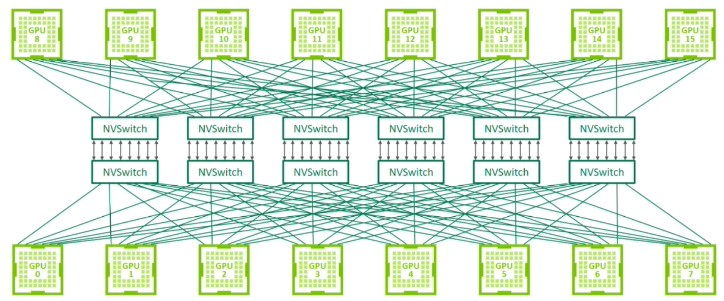
Within a node: NVLink connects GPUs directly, bypass CPU
    
Across nodes: NVSwitch connects GPUs directly, bypass Ethernet

 - Each H100 has 18 NVLink 4.0 links, for a total of 900GB/s 
 - In comparison, memory bandwidth for HBM is 3.9 TB/s

### 使用硬件
    
NVIDIA Collective Communication Library (NCCL)
 - NCCL translates collective operations into low-level packets that are sent between GPUs.
    
Detects topology of hardware (e.g., number of nodes, switches, NVLink/PCIe)
    
Optimizes the path between GPUs
    
Launches CUDA kernels to send/receive data

### 比NCCL更高级的python库：PyTorch distributed library (torch.distributed)

    
Provides clean interface for collective operations (e.g., all_gather_into_tensor)
    
Supports multiple backends for different hardware: gloo (CPU), nccl (GPU)
    
Also supports higher-level algorithms (e.g., FullyShardedDataParallel) [not used in this course]

all-reduce = reduce-scatter + all-gather
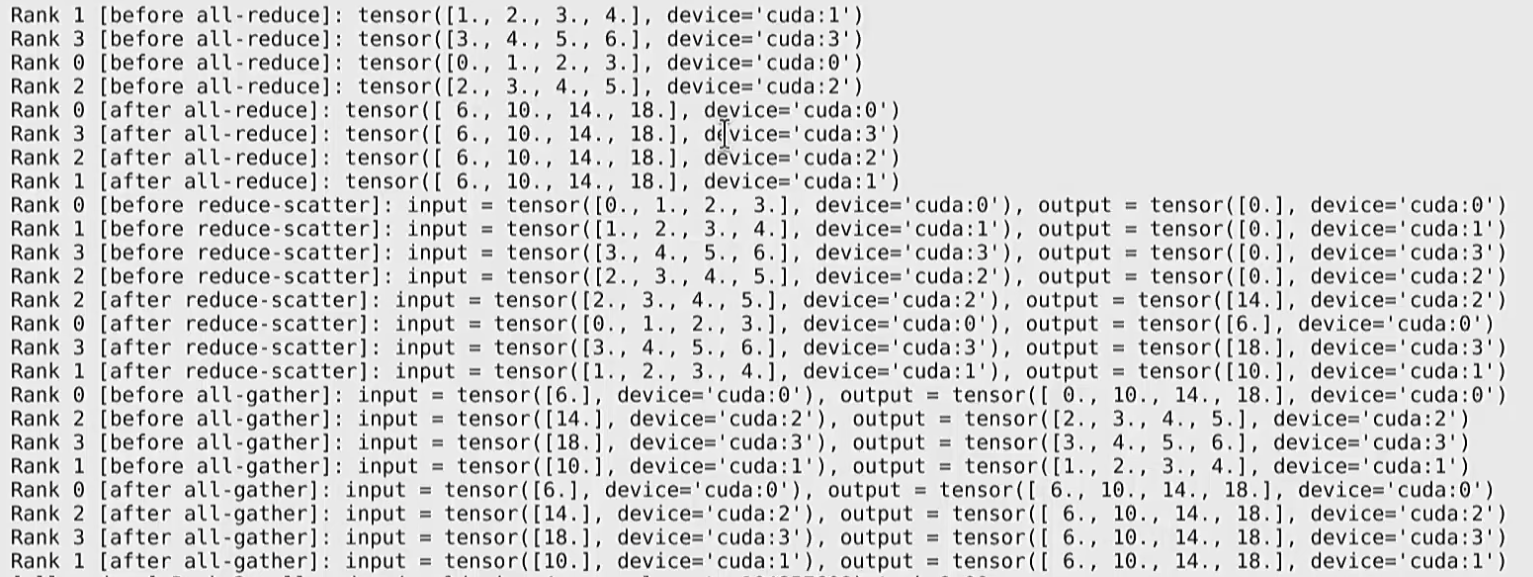

## distributed training(代码在`distributed_training.py`)
#### data parallelism
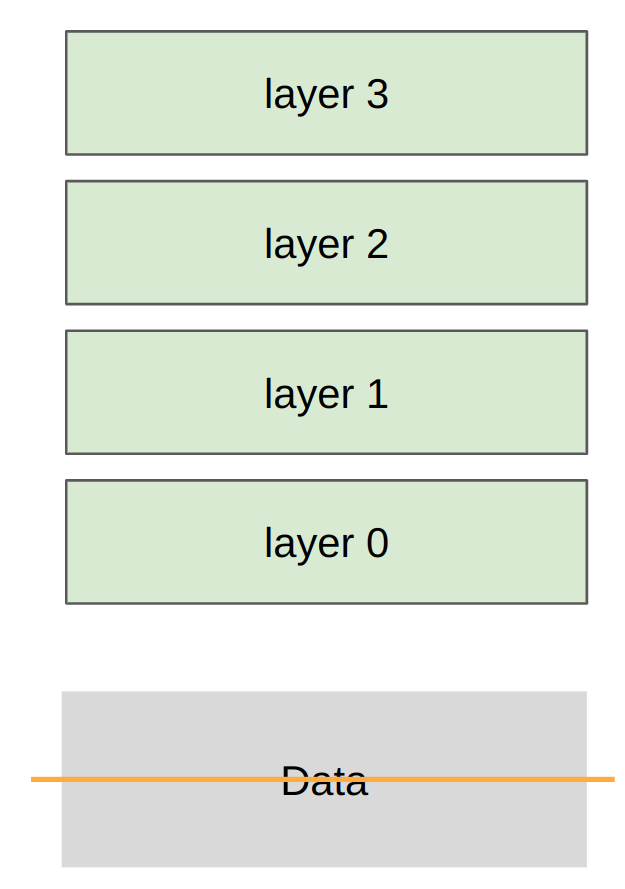

#### tensor parallelism
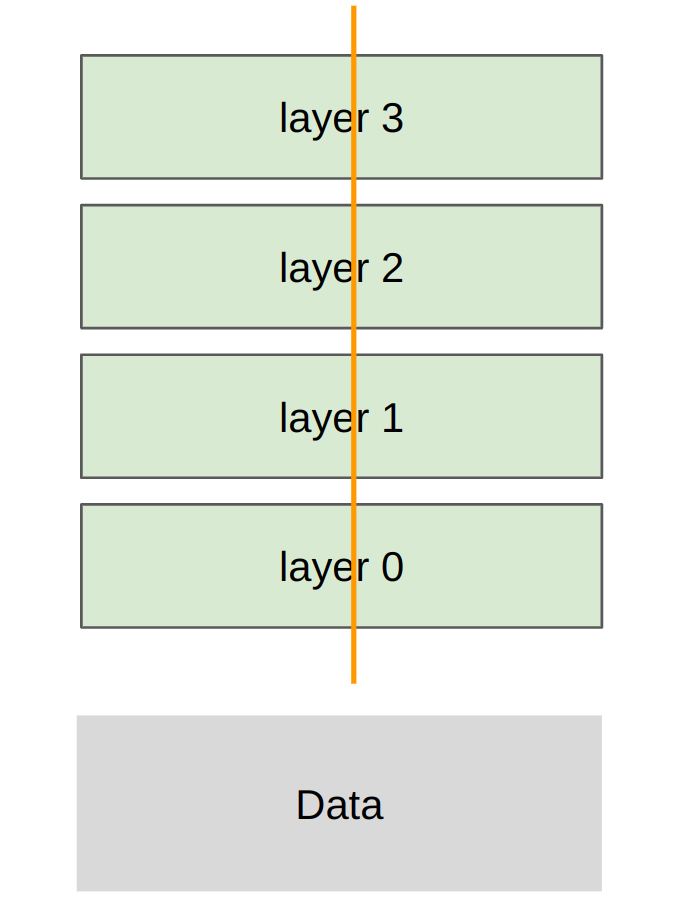

#### pipeline parallelism
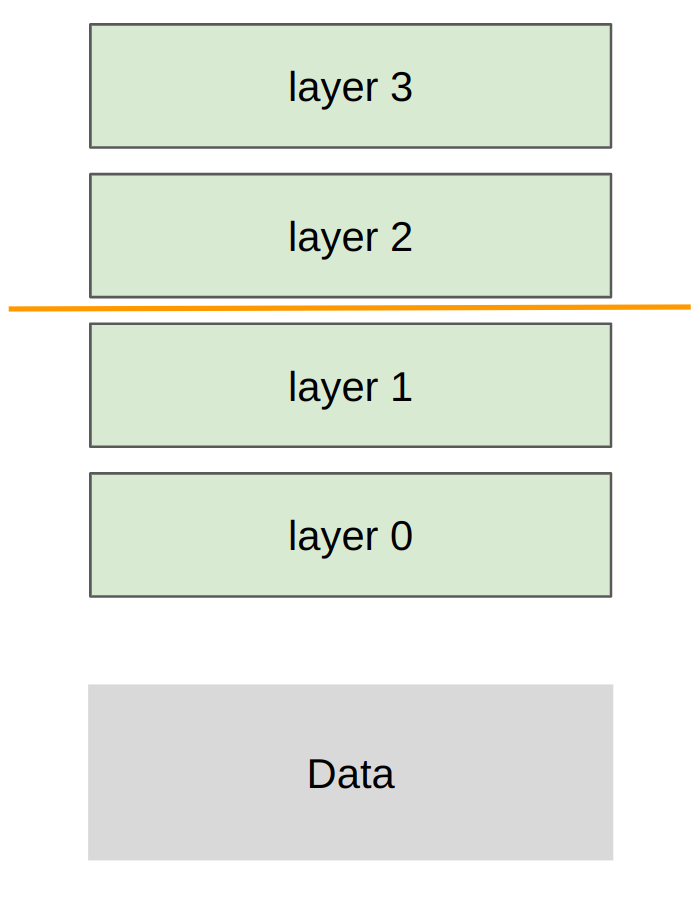

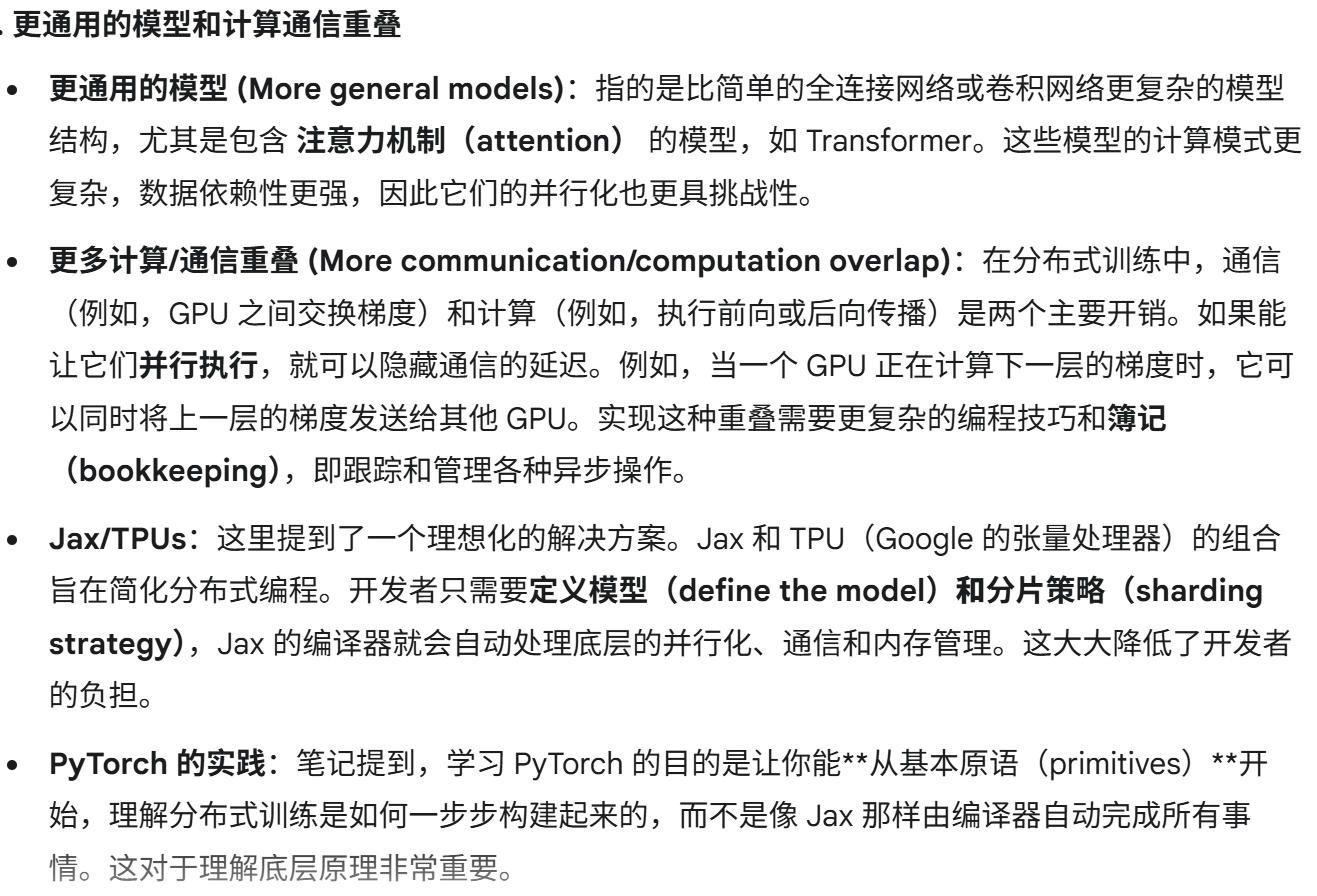

### 并行化总结
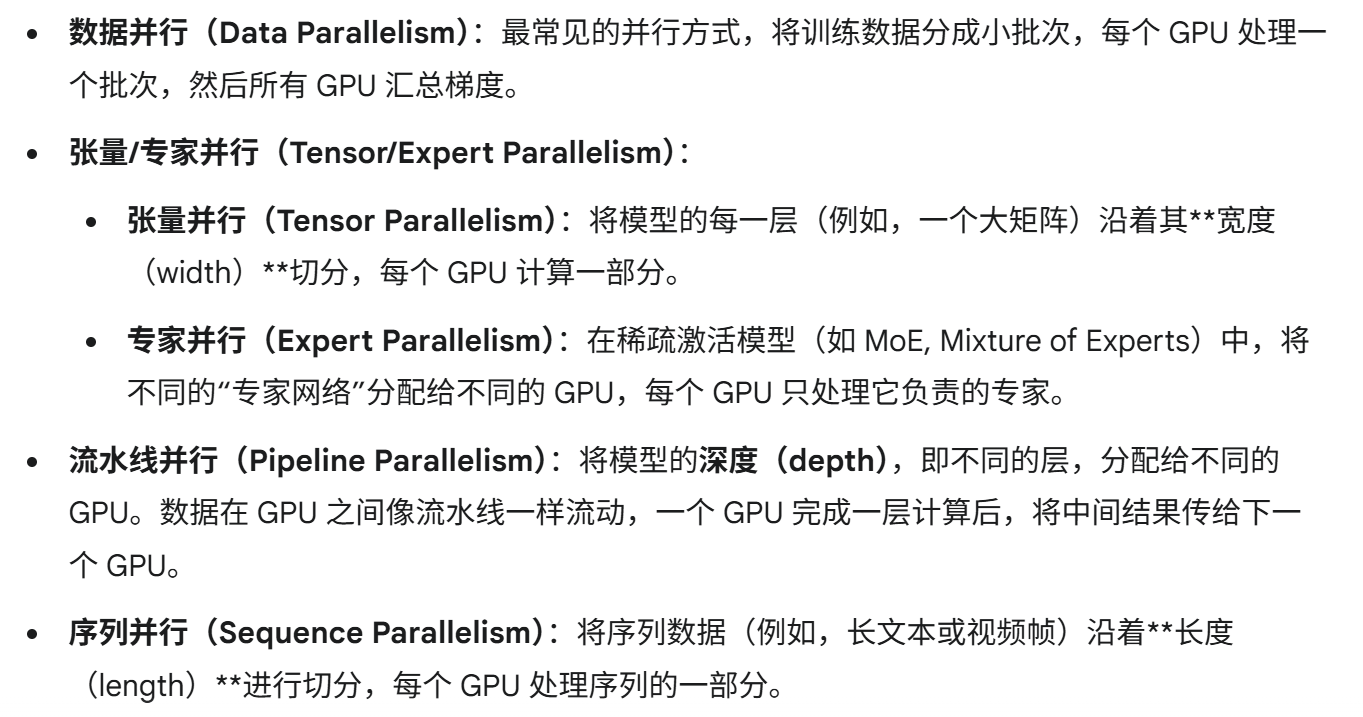

三种数据处理策略：在分布式训练中，通常有三种方式来处理中间激活值（activations）以节省内存：

 - 重新计算（re-compute）：在反向传播时重新计算前向传播的激活值。这可以节省内存，但会增加计算开销。

 - 存储在内存中（store in memory）：直接将激活值存储在 GPU 内存中。这速度最快，但需要大量的显存。

 - 存储在另一块 GPU 内存中并通信（store in another GPUs memory and communicate）：将激活值分片存储在其他 GPU 的内存中。这是一种介于速度和内存之间的平衡策略，但需要额外的通信开销。